# Machine Learning

* This notebook evalutates standard classifiers from scikit-learn on the provided features selection.

In [1]:
import time
import os

import IPython.display as ipd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle


from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, LabelBinarizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import cohen_kappa_score
from sklearn.decomposition import PCA
from matplotlib import cm
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.under_sampling import EditedNearestNeighbours

import utils

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18, 8)
plt.rcParams["legend.facecolor"] = "white"
plt.rcParams["legend.borderpad"] = 1
plt.rcParams["axes.grid"] = False
pallete_colors = cm.get_cmap('Set3', 16)
subset_size = "large"

C:\Anaconda3\envs\tfm\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
AUDIO_DIR = os.environ.get('AUDIO_DIR',
                           'C:\\Users\\lrubio\\Desktop\\TFM\\tfm-mir\\data\\fma_small')

# Loading data created in first notebook and preporcessing
file_tracks =  open('../data/fma_metadata/tracks.pkl', 'rb') 
tracks = pickle.load(file_tracks)
file_features =  open('../data/fma_metadata/features.pkl', 'rb') 
features = pickle.load(file_features)
genres = utils.load('../data/fma_metadata/genres.csv')

tracks.shape, features.shape, genres.shape

((104343, 52), (104343, 518), (163, 4))

## Subset

In [3]:
subset = tracks.index[tracks['set', 'subset'] <= subset_size]

assert subset.isin(tracks.index).all()
assert subset.isin(features.index).all()

tracks = tracks.loc[subset]
features_all = features.loc[subset]

tracks.shape, features_all.shape

((104343, 52), (104343, 518))

In [4]:
train = tracks.index[(tracks['set', 'split'] == 'training')
                     | (tracks['set', 'split'] == 'validation')]
test = tracks.index[tracks['set', 'split'] == 'test']

print('{} training examples, {} testing examples'.format(
    *map(len, [train, test])))

genres = list(LabelEncoder().fit(tracks['track', 'genre_top']).classes_)
#genres = list(tracks['track', 'genre_top'].unique())
print('Top genres ({}): {}'.format(len(genres), genres))
genres = list(MultiLabelBinarizer().fit(
    tracks['track', 'genres_all']).classes_)
print('All genres ({}): {}'.format(len(genres), genres))

93222 training examples, 11121 testing examples
Top genres (16): ['Blues', 'Classical', 'Country', 'Easy Listening', 'Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Jazz', 'Old-Time / Historic', 'Pop', 'Rock', 'Soul-RnB', 'Spoken']
All genres (161): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 27, 30, 31, 32, 33, 36, 37, 38, 41, 42, 43, 45, 46, 47, 49, 53, 58, 63, 64, 65, 66, 70, 71, 74, 76, 77, 79, 81, 83, 85, 86, 88, 89, 90, 92, 94, 97, 98, 100, 101, 102, 103, 107, 109, 111, 113, 117, 118, 125, 130, 137, 138, 166, 167, 169, 170, 171, 172, 173, 174, 176, 177, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 214, 224, 232, 236, 240, 247, 250, 267, 286, 296, 297, 311, 314, 322, 337, 359, 360, 361, 362, 374, 377, 378, 400, 401, 404, 428, 439, 440, 441, 442, 443, 444, 456, 465, 468, 491, 493, 495, 502, 504, 514, 524, 538, 539, 542, 567, 580, 602, 619, 651, 659, 693, 695, 741, 763, 808, 810, 811, 906, 1032,

In [5]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Oranges,
                          url_image='graph.png'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')
    
    # Add title
    plt.title(title, pad=20)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig(url_image)

    return ax, cm

### Pre-processing

In [6]:
def pre_process(tracks, features, columns, multi_label=False, verbose=False, pca_active=False):

    if not multi_label:
        # Assign an integer value to each genre.
        enc = LabelEncoder()
        labels = tracks['track', 'genre_top']
    else:
        # Create an indicator matrix.
        enc = MultiLabelBinarizer()
        labels = tracks['track', 'genres_all']

    if(pca_active and len(columns) == 0):
        X_train = PCA(n_components=4,
                      whiten=True).fit_transform(
            features.loc[train].values)
        X_test = PCA(n_components=4,
                     whiten=True).fit_transform(
            features.loc[test].values)
    else:
        X_train = features.loc[train, columns].values
        X_test = features.loc[test, columns].values

    y_train = enc.fit_transform(labels[train])
    y_test = enc.transform(labels[test])
    classes = enc.classes_

    X_train, y_train = shuffle(X_train, y_train, random_state=42)

    # Standardize features by removing the mean and scaling to unit variance.
    scaler = StandardScaler(copy=False)
    scaler.fit_transform(X_train)
    scaler.transform(X_test)

    return y_train, y_test, X_train, X_test, classes

In [7]:
def test_classifiers_features(classifiers, feature_sets, multi_label=False, pca_active=False):
    columns = list(classifiers.keys()).insert(0, 'dim')
  
    scores = pd.DataFrame(columns=columns, index=feature_sets.keys())
    times = pd.DataFrame(columns=classifiers.keys(), index=feature_sets.keys())
    for fset_name, fset in tqdm_notebook(feature_sets.items(), desc='features'):
        y_train, y_val,y_test, X_train,X_val, X_test = pre_process(
            tracks, features_all, fset, multi_label, False, pca_active)
        scores.loc[fset_name, 'dim'] = X_train.shape[1]
        for clf_name, clf in classifiers.items():
            t = time.process_time()
            clf.fit(X_train, y_train)
            predicted = clf.predict(X_test)
            score = cohen_kappa_score(predicted, y_test)
            scores.loc[fset_name, clf_name] = score
            times.loc[fset_name, clf_name] = time.process_time() - t
    return scores, times


def format_scores(scores):
    def highlight(s):
        is_max = s == max(s[1:])
        return ['background-color: yellow' if v else '' for v in is_max]
    scores = scores.style.apply(highlight, axis=1)
    return scores.format('{:.2%}', subset=pd.IndexSlice[:, scores.columns[1]:])

## Ensemble

Based on this criterias:

* Best Accuracy
* Time excecution
* Diversity in model construction

We dicided to buil an ensemble model using `mfcc/contrast/chroma/centroid/tonnetz` features, with this models:

* _Xtreme Gradient Boosting_
* _Logistic Regresion_
* _Linear Support Vector Machine_

In [8]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, cohen_kappa_score, make_scorer, confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.utils.multiclass import unique_labels

In [9]:
kappa_scorer = make_scorer(cohen_kappa_score)

final_columns = ['mfcc', 'spectral_contrast',
                 'chroma_cens', 'spectral_centroid',
                 'tonnetz']

y_train, y_test, X_train, X_test, name_classes = pre_process(
    tracks, features, final_columns, False)

### Xtreme Gradient Boostig

In [ ]:
param_grid_xgb = {
    'xgb__max_depth': [6, 12, 24, 48],
    'xgb__n_estimators': [50, 100, 200],
    'xgb__learning_rate': [0.0001, 0.001, 0.01, 0.1],
    'xgb__colsample_bytree': [0.3, 0.5],
}

inner_cv = StratifiedKFold(n_splits=3,
                           shuffle=True,
                           random_state=1212)

xgb_estimator = XGBClassifier(n_jobs=-1,
                              random_state=1212)

enn = EditedNearestNeighbours(n_jobs=-1,
                              random_state=1212)

pipeline_xgb = Pipeline([('smote_xgb', enn),
                         ('xgb', xgb_estimator)])

gsearch_xgb = RandomizedSearchCV(estimator=pipeline_xgb,
                                 cv=inner_cv.split(X_train, y_train),
                                 param_distributions=param_grid_xgb,
                                 scoring='accuracy',
                                 refit=True,
                                 return_train_score=True,
                                 n_jobs=-1,
                                 verbose=2)

gsearch_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [19]:
file_xgb = open('../data/fma_metadata/models/xgb_b.pkl', 'wb') 
pickle.dump(gsearch_xgb.best_estimator_, file_xgb)

In [10]:
file_xgb =  open('../data/fma_metadata/models/xgb_b.pkl', 'rb') 
xgb_model = pickle.load(file_xgb)

### Logistic Regression

In [11]:
param_grid_lr = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
}

lr_estimator = LogisticRegression(n_jobs=-1, solver="lbfgs")

pipeline_lr = Pipeline([('smote_xgb', enn),
                        ('xgb', lr_estimator)])

gsearch_lr = RandomizedSearchCV(estimator=pipeline_lr,
                                cv=inner_cv.split(X_train, y_train),
                                param_distributions=param_grid_lr,
                                scoring=kappa_scorer,
                                refit=True,
                                n_iter=7,
                                return_train_score=True,
                                n_jobs=-1,
                                verbose=2)

gsearch_lr.fit(X_train, y_train)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Done  17 out of  21 | elapsed: 12.2min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed: 12.8min finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x000001DBA6C98D58>,
          error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=7, n_jobs=-1,
          param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=make_scorer(cohen_kappa_score),
          verbose=2)

In [22]:
file_lr = open('../data/fma_metadata/models/lr_b.pkl', 'wb') 
pickle.dump(gsearch_lr.best_estimator_, file_lr)

In [11]:
file_lr =  open('../data/fma_metadata/models/lr_b.pkl', 'rb') 
lr_model = pickle.load(file_lr)

### Linear Support Vector Machine

In [12]:
param_grid_lsvm = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],

}

lsvm_estimator = LinearSVC(random_state=1212)

pipeline_lsvm = Pipeline([('smote_xgb', enn),
                          ('xgb', lsvm_estimator)])


gsearch_lsvm = RandomizedSearchCV(estimator=pipeline_lsvm,
                                  cv=inner_cv.split(X_train, y_train),
                                  param_distributions=param_grid_lsvm,
                                  scoring=kappa_scorer,
                                  refit=True,
                                  n_iter=7,
                                  return_train_score=True,
                                  n_jobs=-1,
                                  verbose=2)

gsearch_lsvm.fit(X_train, y_train)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Done  17 out of  21 | elapsed: 83.8min remaining: 19.7min
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed: 115.8min finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x000001DB9A804D00>,
          error_score='raise',
          estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=1212, tol=0.0001,
     verbose=0),
          fit_params=None, iid=True, n_iter=7, n_jobs=-1,
          param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=make_scorer(cohen_kappa_score),
          verbose=2)

In [25]:
file_lsvm = open('../data/fma_metadata/models/lsvm_b.pkl', 'wb') 
pickle.dump(gsearch_lsvm.best_estimator_, file_lsvm)

In [12]:
file_lsvm =  open('../data/fma_metadata/models/lsvm_b.pkl', 'rb') 
lsvm_model = pickle.load(file_lsvm)

### Voting Ensemble

In [ ]:
voting_classifier = VotingClassifier(estimators=[('xgb', xgb_model),
                                                 ('lr', lr_model),
                                                 ('lsvm', lsvm_model)], voting='hard')

voting_classifier.fit(X_train, y_train)

In [43]:
file_ensemble = open('../data/fma_metadata/models/ensemble_b.pkl', 'wb') 
pickle.dump(voting_classifier, file_ensemble)

In [67]:
file_ensemble = open('../data/fma_metadata/models/ensemble_b.pkl', 'rb')
voting_classifier = pickle.load(file_ensemble)

#### Confusion Matrix

In [ ]:
y_predict = voting_classifier.predict(X_test)

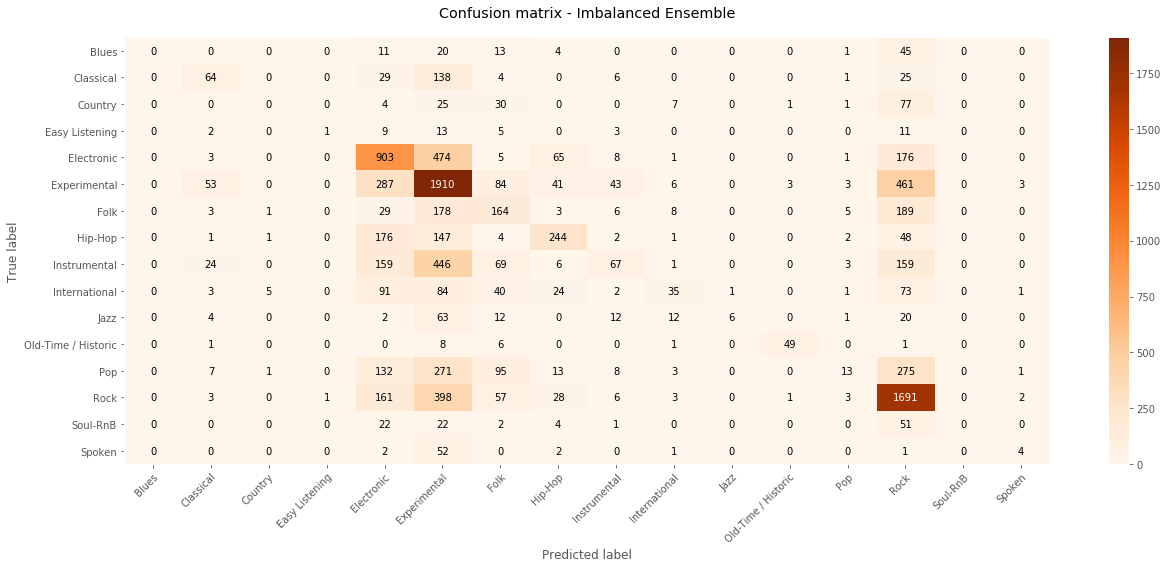

In [101]:
_, cm = plot_confusion_matrix(y_test, y_predict, classes=name_classes,
                              title='Confusion matrix - Balanced Ensemble',
                              url_image='graphs/cm/cm-be.png')

In [70]:
print(f"Total Accuracy: {round(accuracy_score(y_test, y_predict)*100,2)}%")
print(f"Total Kappa: {round(cohen_kappa_score(y_test, y_predict)*100,2)}%")

Total Accuracy: 46.32%
Total Kappa: 33.22%


#### Accuracy by class:

In [77]:
pd.DataFrame(np.column_stack((name_classes,
                              np.round((cm.diagonal()/cm.sum(axis=1)) * 100, 2))),
             columns=["Music Genre", "Accuracy %"])

,Music Genre,Accuracy %
0,Blues,0
1,Classical,23.97
2,Country,0
3,Easy Listening,2.27
4,Electronic,55.2
5,Experimental,66
6,Folk,27.99
7,Hip-Hop,38.98
8,Instrumental,7.17
9,International,9.72
